MOVIE RECCOMENDATIONS

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt


In [3]:
data=pd.read_csv(r"C:\Users\Swarathmica\Downloads\netflix_data.csv\netflix_data.csv")
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Combine features to create a 'soup' of words
data['soup'] = data['cast'].fillna('') + ' ' + data['director'].fillna('') + ' ' + data['listed_in'].fillna('') + ' ' + data['description'].fillna('')

# Create a TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Replace NaN with an empty string
data['soup'] = data['soup'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(data['soup'])

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get recommendations based on the cosine similarity score
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = data[data['title'] == title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return data['title'].iloc[movie_indices]

# Test the function
print(get_recommendations('Blood & Water'))


1514            Diamond City
1593        Kings of Jo'Burg
4475                Shirkers
108                Dive Club
2184                Get Even
4271              Lion Pride
218           Titletown High
5479             The Keepers
4030           Disappearance
4487    Accidentally in Love
Name: title, dtype: object


In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Create a user-item interaction matrix
data['userId'] = data['show_id'].str.extract('(\d+)').astype(int)
user_item_matrix = data.pivot_table(index='userId', columns='title', values='release_year', aggfunc='mean').fillna(0)

# Convert the matrix to a sparse matrix
sparse_matrix = csr_matrix(user_item_matrix.values)

# Compute the cosine similarity
user_similarity = cosine_similarity(sparse_matrix, sparse_matrix)

# Create a DataFrame of the user similarity
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Predict function
def predict_ratings(user_similarity, user_item_matrix):
    mean_user_rating = user_item_matrix.mean(axis=1)
    ratings_diff = (user_item_matrix.T - mean_user_rating).T
    pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T
    return pred

# Make predictions
predictions = predict_ratings(user_similarity, user_item_matrix.values)
predictions_df = pd.DataFrame(predictions, index=user_item_matrix.index, columns=user_item_matrix.columns)

# Function to recommend movies for a user
def recommend_movies(user_id, predictions_df, num_recommendations):
    sorted_user_predictions = predictions_df.iloc[user_id - 1].sort_values(ascending=False)
    recommendations = sorted_user_predictions.index[:num_recommendations]
    return recommendations

# Test the recommendation system
print(recommend_movies(1, predictions_df, 10))


Index(['Dick Johnson Is Dead', '#Alive', 'Rip Tide', 'Rilakkuma and Kaoru',
       'Rim of the World', 'Rimba Racer', 'Ringan', 'Riot',
       'Riphagen - The Untouchable', 'Rita'],
      dtype='object', name='title')


C:\Users\Swarathmica\AppData\Local\Temp\ipykernel_10128\366824312.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recommendations.values, y=recommendations.index, palette="viridis")


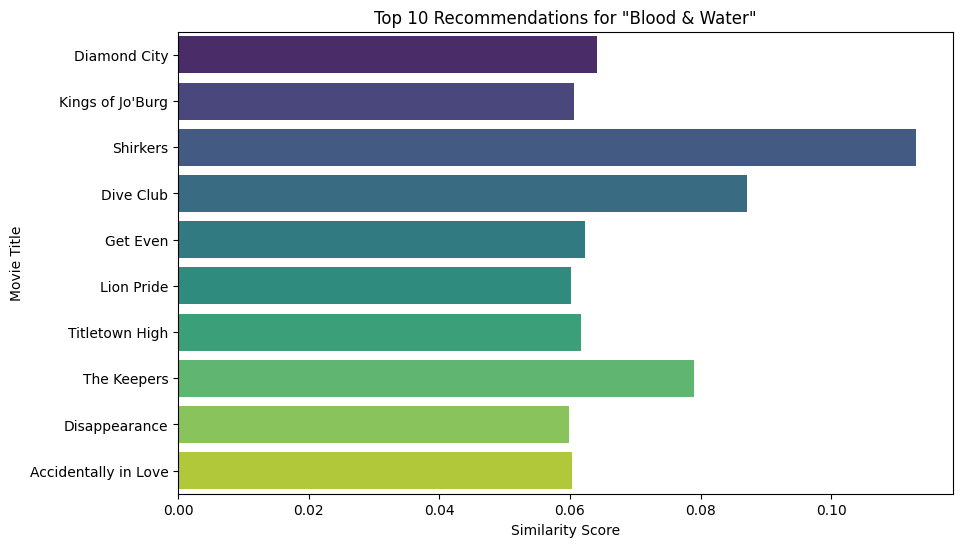

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_recommendations(title, recommendations):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=recommendations.values, y=recommendations.index, palette="viridis")
    plt.title(f'Top 10 Recommendations for "{title}"')
    plt.xlabel('Similarity Score')
    plt.ylabel('Movie Title')
    plt.show()

# Get top recommendations
recommendations = get_recommendations('Blood & Water')
recommendations_scores = cosine_sim[data[data['title'] == 'Blood & Water'].index[0]][data[data['title'].isin(recommendations)].index]

# Plot
plot_recommendations('Blood & Water', pd.Series(recommendations_scores, index=recommendations))


C:\Users\Swarathmica\AppData\Local\Temp\ipykernel_10128\3780000798.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="cubehelix")


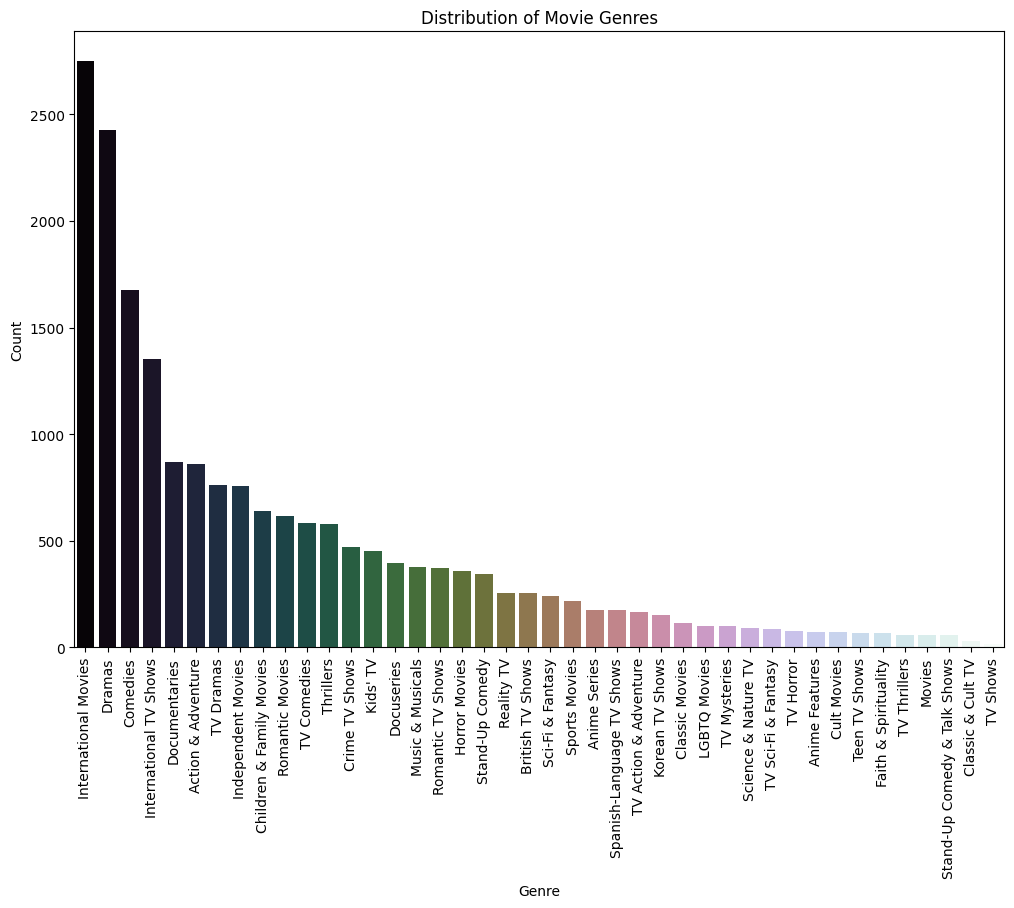

In [7]:
def plot_genre_distribution(data):
    genre_counts = data['listed_in'].str.split(', ', expand=True).stack().value_counts()
    plt.figure(figsize=(12, 8))
    sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="cubehelix")
    plt.title('Distribution of Movie Genres')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

# Plot
plot_genre_distribution(data)
